In [125]:
import os.path as osp

import numpy as np

import time

from general_tools.in_out.basics import files_in_subdirs

from geo_tool import Point_Cloud

from external_tools.binvox_rw.binvox_rw import read_as_3d_array

from tf_lab.data_sets.shape_net import snc_category_to_synth_id

from tf_lab.point_clouds.autoencoder import AutoEncoder, Configuration

import tensorflow as tf

from general_tools.notebook.tf import reset_tf_graph

from tflearn.layers.conv import conv_3d, conv_3d_transpose

from tf_lab.data_sets.numpy_dataset import NumpyDataset

from tf_lab.in_out.basics import Data_Splitter

from tflearn.layers.core import fully_connected

In [2]:
%matplotlib nbagg
%load_ext autoreload

In [5]:
from multiprocessing import Pool

def read_bin_vox_file(binvox_filename, perm_axis=(0,1,2), expand_last_dim=True, dtype=np.float32):
    with open(binvox_filename, 'rb') as f:
        vol = read_as_3d_array(f)
        
    vol = vol.data.astype(dtype)    
    vol = vol.transpose(perm_axis)    

    if expand_last_dim:
        vol = np.expand_dims(vol, vol.ndim)
    
    return vol

def read_shape_net_bin_vox(binvox_filename):
    tokens = binvox_filename.split('/')
    model_id = tokens[-2]
    class_id = tokens[-3]
    vol_grid = read_bin_vox_file(binvox_filename, perm_axis=(0,2,1))
    return vol_grid, model_id, class_id
    

def load_voxel_grids_from_filenames(file_names, n_threads=1, loader=read_shape_net_bin_vox, 
                                    verbose=False, dtype=np.float32):
    assert(len(file_names) > 1)
    voxel_grid, _, _ = loader(file_names[0])
    voxel_dims = list(voxel_grid.shape)    
    voxel_grids = np.empty([len(file_names)]+voxel_dims, dtype=dtype)
    model_names = np.empty([len(file_names)], dtype=object)
    class_ids = np.empty([len(file_names)], dtype=object)
    pool = Pool(n_threads)

    for i, data in enumerate(pool.imap(loader, file_names)):
        voxel_grids[i], model_names[i], class_ids[i] = data

    pool.close()
    pool.join()

    if len(np.unique(model_names)) != len(voxel_grids):
        warnings.warn('Point clouds with the same model name were loaded.')

    if verbose:
        print('{0} voxel-grids were loaded. They belong in {1} shape-classes.'.format(len(voxel_grids), len(np.unique(class_ids))))

    return voxel_grids, model_names, class_ids

In [424]:
top_data_dir = '/orions4-zfs/projects/optas/DATA'

class_name = 'car'

syn_id = snc_category_to_synth_id()[class_name]

# print syn_id

top_voxel_dir = osp.join(top_data_dir, 'Voxels/ShapeNetVox32')

splitter = Data_Splitter(top_voxel_dir, data_file_ending='.binvox')

splits = ['train', 'test', 'val']

in_data = dict()

for s in splits:
    split_file = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/single_class_splits/' + syn_id + '/85_5_10/', s + '.txt')    
    data_in_split = splitter.load_splits(split_file, full_path=False)
    data_in_split_full_path = []
    for d in data_in_split:
        _, model_id = d.split('_')
        d_file = osp.join(top_voxel_dir, syn_id, model_id, 'model.binvox')
        data_in_split_full_path.append(d_file)
    voxel_grids, model_names, class_ids = load_voxel_grids_from_filenames(data_in_split_full_path, n_threads=10)
    in_data[s] = NumpyDataset([voxel_grids, class_ids + '_' + model_names], ['voxels', 'labels'])

02958343


In [396]:
b_neck = 128
from tflearn.layers.normalization import batch_normalization

def three_d_conv_encoder(in_signal):
    layer = in_signal
    layer = conv_3d(layer, nb_filter=32, filter_size=8, strides=2, activation='relu')
    layer = conv_3d(layer, nb_filter=32, filter_size=6, strides=2, activation='relu')
    layer = batch_normalization(layer)
    layer = conv_3d(layer, nb_filter=64, filter_size=4, strides=2, activation='relu')    
    layer = conv_3d(layer, nb_filter=64, filter_size=2, strides=2, activation='relu')
    layer = batch_normalization(layer)
    layer = conv_3d(layer, nb_filter=b_neck, filter_size=2, strides=2, activation='relu')
    return layer

def three_d_conv_decoder(in_signal):
    layer = in_signal
    layer = conv_3d_transpose(layer, nb_filter=64, filter_size=4, strides=2, output_shape=[2,2,2], activation='relu')
    layer = conv_3d_transpose(layer, nb_filter=32, filter_size=8, strides=2, output_shape=[4,4,4], activation='relu')    
    layer = batch_normalization(layer)
#     layer = conv_3d_transpose(layer, nb_filter=32, filter_size=8, strides=4, output_shape=[8,8,8], activation='relu')    
    layer = conv_3d_transpose(layer, nb_filter=32, filter_size=8, strides=2, output_shape=[8,8,8], activation='relu')    
    layer = conv_3d_transpose(layer, nb_filter=1, filter_size=8, strides=4, output_shape=[32,32,32], activation='linear')
    return layer

In [330]:
# # in_signal = voxel_ae.x
# def three_d_conv_encoder_t(in_signal):
#     layer = conv_3d(in_signal, nb_filter=32, filter_size=16, strides=2, activation='relu')
#     layer = conv_3d(layer, nb_filter=48, filter_size=8, strides=2, activation='relu')
#     layer = conv_3d(layer, nb_filter=64, filter_size=4, strides=2, activation='relu')
# #     layer = fully_connected(layer, 128, activation='relu')
#     layer = fully_connected(layer, 256, activation='relu')
#     layer = fully_connected(layer, 64*80, activation='relu')
#     layer = tf.reshape(layer, [-1, 4, 4, 4, 80])
#     return layer
    
# def three_d_conv_decoder_t(in_signal):    
# #     return tf.zeros([16, 32, 32, 32, 1])
#     layer = conv_3d_transpose(in_signal, nb_filter=64, filter_size=8, strides=2, output_shape=[8,8,8], activation='relu')
#     layer = conv_3d_transpose(layer, nb_filter=48, filter_size=16, strides=2, output_shape=[16, 16, 16], activation='relu')
#     layer = conv_3d_transpose(layer, nb_filter=1, filter_size=16, strides=2, output_shape=[32, 32, 32], activation='linear')
#     return layer

In [397]:
class Voxel_Based_AE(AutoEncoder):    
    def __init__(self, name, configuration, graph=None):
        c = configuration
        self.configuration = c
        AutoEncoder.__init__(self, name, graph, configuration)
        self.z = c.encoder(self.x)
        self.x_reconstr = c.decoder(self.z)
        self._create_loss()
        init = tf.global_variables_initializer() # TODO -> make part of Neural_Net
        self.start_session()

    def _create_loss(self):
        self.loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=self.x, logits=self.x_reconstr)
        self.loss = tf.reduce_mean(self.loss)
        self._setup_optimizer()
        
    def _setup_optimizer(self):
        c = self.configuration
        self.lr = c.learning_rate
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.lr)
        self.train_step = self.optimizer.minimize(self.loss)
        
    def _single_epoch_train(self, train_data, batch_size, only_fw=False):
        n_examples = train_data.n_examples
        epoch_loss = 0.
        n_batches = int(n_examples / batch_size)
        start_time = time.time()
        if only_fw:
            fit = self.reconstruct
        else:
            fit = self.partial_fit

        # Loop over all batches
        for _ in xrange(n_batches):
            batch_i, _ = train_data.next_batch(batch_size)
            _, loss = fit(batch_i)
            # Compute average loss
            epoch_loss += loss
        epoch_loss /= n_batches
        duration = time.time() - start_time
        return epoch_loss, duration

In [398]:
voxel_dims = list(in_data['train'].voxels.shape[1:])

conf = Configuration(n_input=voxel_dims, 
                     encoder=three_d_conv_encoder, 
                     decoder=three_d_conv_decoder,
                     learning_rate = 0.001,
                    )

In [399]:
reset_tf_graph()
voxel_ae = Voxel_Based_AE('test_', conf)

In [400]:
max_epochs = 100
batch_size = 128
for i in range(1, max_epochs + 1):
    print i, voxel_ae._single_epoch_train(in_data['train'], batch_size=batch_size)[0]
    if i % 10 == 0:
        print i, voxel_ae._single_epoch_train(in_data['test'], batch_size=batch_size, only_fw=True)[0]

1 0.294290162457
2 0.172882285052
3 0.137282793224
4 0.117951612837
5 0.109014013575
6 0.101335604323
7 0.0963956250085
8 0.0926279130909
9 0.0881748404768
10 0.0857887751526
10 0.0993538960814
11 0.0837546471092
12 0.0805038352807
13 0.0784903054436
14 0.0769583842821
15 0.0753145663275
16 0.0718003547854
17 0.0709837199913
18 0.0699490176307
19 0.0685487095681
20 0.0670060118867
20 0.078194399178
21 0.0669814802706
22 0.065598632892
23 0.0639726400375
24 0.064360502445
25 0.0616952065792
26 0.0619528829224
27 0.0606155143844
28 0.0594248860247
29 0.0591549807125
30 0.0572085994813
30 0.0702016428113
31 0.056450372686
32 0.0567618946234
33 0.0567458523644
34 0.0546065055662
35 0.053994337966
36 0.0531277926432
37 0.0523726936844
38 0.0535507678158
39 0.0522056637539
40 0.050594715029
40 0.0675495147705
41 0.0506660970549
42 0.0499906997714
43 0.0507364509834
44 0.0498670528332
45 0.0487335581746
46 0.0492534854346
47 0.0479735235373
48 0.0483953847653
49 0.0467514950368
50 0.045858241

In [401]:
def binary_voxel_grid_iou(vol_a, vol_b):
    """  vol_a, vol_b are 3-dim voxels grids. Each voxel is 1 or 0"""
    intersection = np.sum(np.logical_and(vol_a, vol_b))
    union = np.sum(np.logical_or(vol_a, vol_b))    
    return intersection / float(union)

In [402]:
feed = in_data['val'].voxels
recon_voxel = voxel_ae.reconstruct(feed)[0]
recon_voxel = voxel_ae.sess.run(tf.sigmoid(recon_voxel))
recon_voxel = np.squeeze(recon_voxel)

In [411]:
iso_value = 0.5
iou = []
feed = np.squeeze(feed)
for i in range(len(recon_voxel)):
    r = recon_voxel[i].copy()
    r[r < iso_value] = 0
    r[r >= iso_value] = 1    
    f = feed[i]
    iou.append(binary_voxel_grid_iou(r, f))
print np.mean(iou)

0.733993722813


<IPython.core.display.Javascript object>


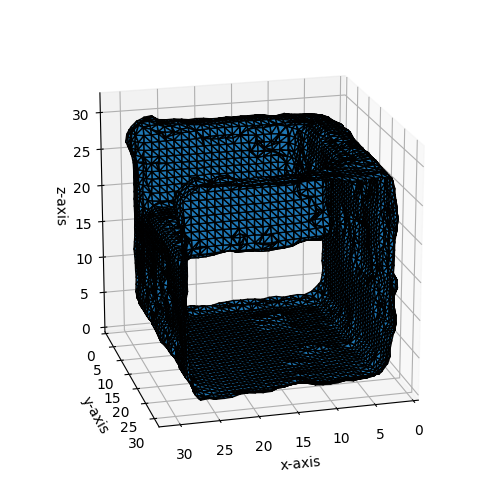

In [423]:
rid = np.random.randint(len(recon_voxel))
# x, y, z = np.where(recon_voxel >= iso_value)
# Point_Cloud(np.vstack((x, y, z)).T).plot(in_u_sphere=False, azim=45);
plot_isosurface(recon_voxel[rid], iso_value)

In [363]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure

def plot_isosurface(voxel_grid, iso_val=0):
    verts, faces, normals, values = measure.marching_cubes(voxel_grid, iso_val)
    x, y, z = zip(*verts)
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces])
    mesh.set_edgecolor('k')
    ax.add_collection3d(mesh)
    ax.set_xlabel("x-axis")
    ax.set_ylabel("y-axis")
    ax.set_zlabel("z-axis")
    d0, d1, d2 = voxel_grid.shape
    ax.set_xlim(0, d0)
    ax.set_ylim(0, d1)
    ax.set_zlim(0, d2)
    plt.tight_layout()
    plt.show()